# Predicting price of the car

## Import libraries

In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import seaborn as sns
sns.set()

## Load data and take a look on them

In [2]:
raw_data = pd.read_csv('car_sales.csv')
raw_data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


In [3]:
raw_data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.000000,4345,4345.000000,4195.000000,4345,4345,4345.000000,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.746935,NaN,161.237284,2.790734,NaN,NaN,2006.550058,NaN
std,NaN,25584.242620,NaN,105.705797,5.066437,NaN,NaN,6.719097,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,86.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,155.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


## Cleanup before splitting data

In [4]:
# Drop Model as there are too many unique values 
data = raw_data.drop(['Model'], axis=1)

### Missing values

In [5]:
# Check how many values are missing
data.isnull().sum()

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
dtype: int64

In [6]:
# Drop all rows with missing values
data_no_nan = data.dropna(axis=0)

# Worser score after Imputation so stayed with dropping rows with missing values
#data_no_nan = data.dropna(subset=['Price'])
#my_imputer = SimpleImputer(missing_values = np.nan, strategy='median')
#data_no_nan.loc[:, 'EngineV'] = my_imputer.fit_transform(data_no_nan[['EngineV']]).ravel()

### Train test split

In [7]:
train_data, test_data = train_test_split(data_no_nan, test_size=0.2, random_state=365)

## Preprocessing of the test data

### Take a look on histograms for numerical data

In [8]:
# Check one more time details about data after dealing with missing values
train_data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
count,3220,3220.000000,3220,3220.000000,3220.000000,3220,3220,3220.000000
unique,7,NaN,6,NaN,NaN,4,2,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN
freq,706,NaN,1229,NaN,NaN,1471,2926,NaN
mean,NaN,19865.970109,NaN,162.895963,2.781894,NaN,NaN,2006.388509
std,NaN,27053.746510,NaN,101.768888,5.151130,NaN,NaN,6.640340
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1978.000000
25%,NaN,6999.000000,NaN,91.000000,1.800000,NaN,NaN,2003.000000
50%,NaN,11500.000000,NaN,157.000000,2.200000,NaN,NaN,2008.000000
75%,NaN,21500.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000


<Axes: xlabel='Price', ylabel='Count'>

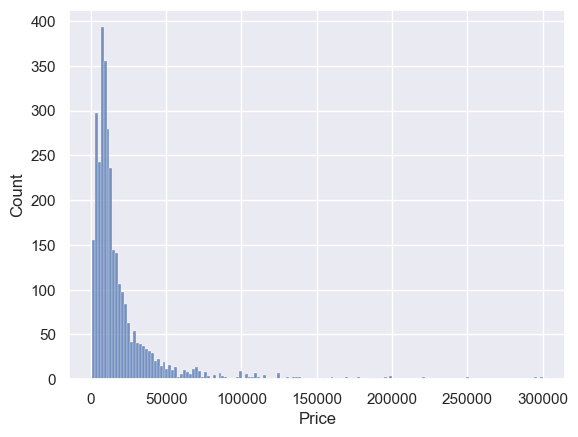

In [9]:
sns.histplot(train_data['Price'])

<Axes: xlabel='Mileage', ylabel='Count'>

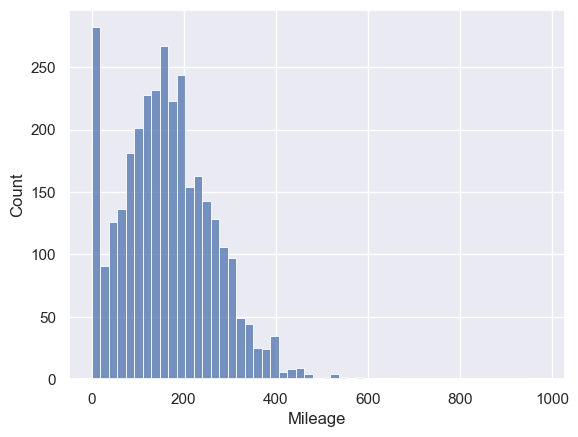

In [10]:
sns.histplot(train_data['Mileage'])

<Axes: xlabel='EngineV', ylabel='Count'>

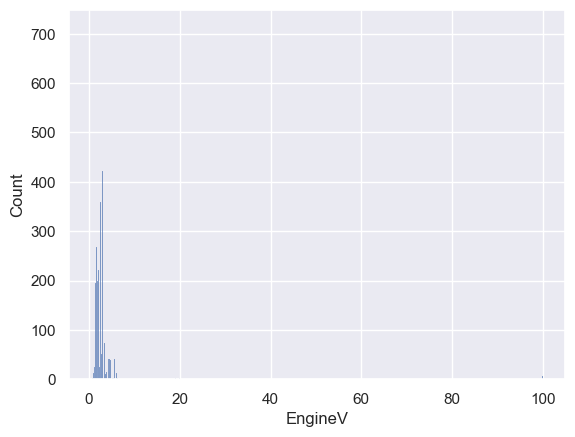

In [11]:
sns.histplot(train_data['EngineV'])

<Axes: xlabel='Year', ylabel='Count'>

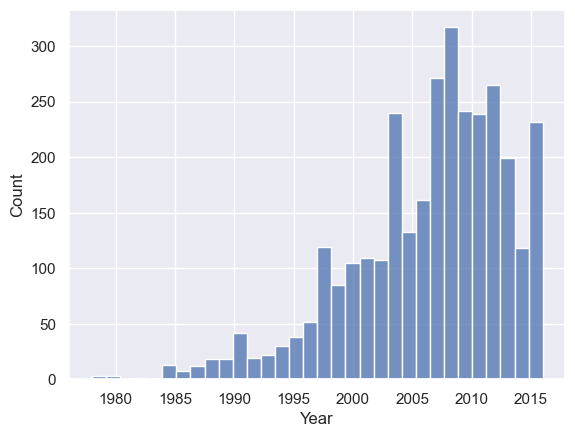

In [12]:
sns.histplot(train_data['Year'])

### Outliers

In [13]:
# Deal with EngineV as there are some incorrect values - there are no values in real bigger than 8
data_prep_1 = train_data[train_data['EngineV'] < 8]

In [14]:
# Remove x% highest prices - 0.5% gives best results
q = data_prep_1['Price'].quantile(0.995)
#q = data_prep_1['Price'].quantile(0.99)
#q = data_prep_1['Price'].quantile(0.95)
data_prep_2 = data_prep_1[data_prep_1['Price'] < q]

In [15]:
# Remove x% highest Milelage - removing 1% gives best results
#q = data_prep_2['Mileage'].quantile(0.995)
q = data_prep_2['Mileage'].quantile(0.99)
data_prep_3 = data_prep_2[data_prep_2['Mileage'] < q]

In [16]:
# Remove x% lowest Year - removing 0.5% gives best results
q = data_prep_3['Year'].quantile(0.005)
#q = data_prep_3['Year'].quantile(0.01)
data_prep_4 = data_prep_3[data_prep_3['Year'] > q]

In [17]:
# Reset indexes after removing some rows
data_cleaned_train = data_prep_4.reset_index(drop=True)
# Without removing outliers score was much worser
# data_cleaned_train = data_no_nan_train.reset_index(drop=True)

In [18]:
# Check dataset once again
data_cleaned_train.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
count,3136,3136.000000,3136,3136.000000,3136.000000,3136,3136,3136.000000
unique,7,NaN,6,NaN,NaN,4,2,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN
freq,687,NaN,1191,NaN,NaN,1436,2848,NaN
mean,NaN,19022.173629,NaN,159.809949,2.462140,NaN,NaN,2006.609375
std,NaN,22233.054531,NaN,95.110222,0.970324,NaN,NaN,6.311845
min,NaN,800.000000,NaN,0.000000,0.600000,NaN,NaN,1986.000000
25%,NaN,7165.000000,NaN,91.750000,1.800000,NaN,NaN,2003.000000
50%,NaN,11700.000000,NaN,156.000000,2.200000,NaN,NaN,2008.000000
75%,NaN,21512.500000,NaN,225.000000,3.000000,NaN,NaN,2012.000000


### Plot numerical variables

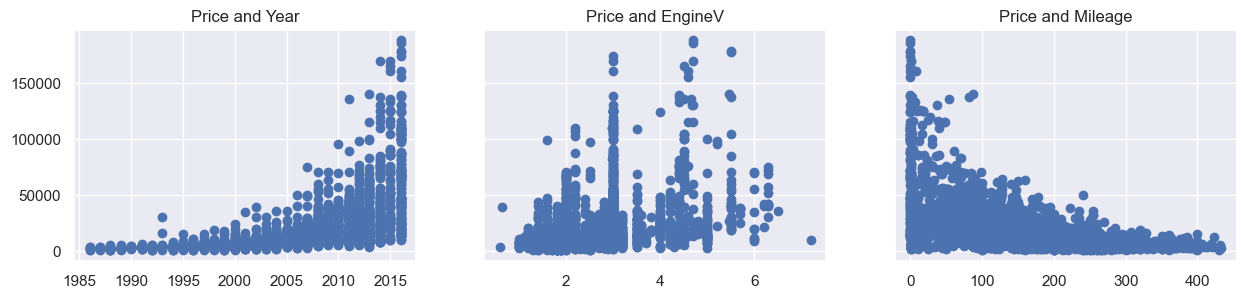

In [19]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15, 3))
ax1.scatter(data_cleaned_train['Year'], data_cleaned_train['Price'])
ax1.set_title('Price and Year')
ax2.scatter(data_cleaned_train['EngineV'], data_cleaned_train['Price'])
ax2.set_title('Price and EngineV')
ax3.scatter(data_cleaned_train['Mileage'], data_cleaned_train['Price'])
ax3.set_title('Price and Mileage')
plt.show()

### Transform price as it has exponential distribution

In [20]:
# Log transformation, add new feature (log_price) to df and remove Price 
log_price_train = np.log(data_cleaned_train['Price'])
data_cleaned_train['Log_Price'] = log_price_train
data_cleaned_train = data_cleaned_train.drop(['Price'], axis=1)


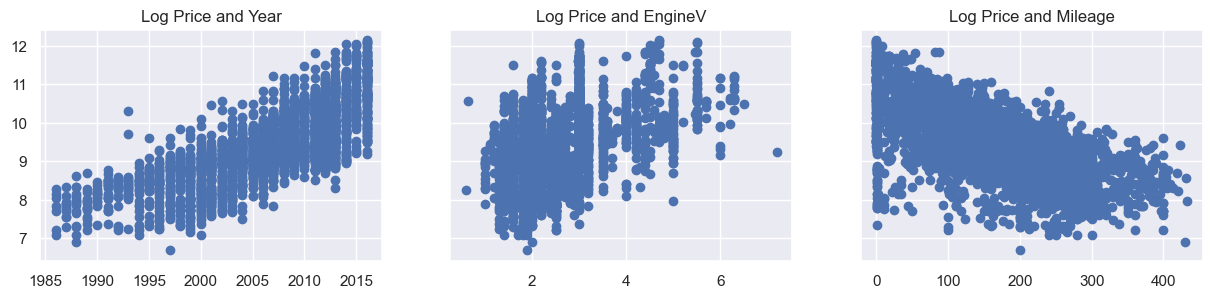

In [21]:
# Plot data again to see changes
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15, 3))
ax1.scatter(data_cleaned_train['Year'], data_cleaned_train['Log_Price'])
ax1.set_title('Log Price and Year')
ax2.scatter(data_cleaned_train['EngineV'], data_cleaned_train['Log_Price'])
ax2.set_title('Log Price and EngineV')
ax3.scatter(data_cleaned_train['Mileage'], data_cleaned_train['Log_Price'])
ax3.set_title('Log Price and Mileage')
plt.show()

### Check multicollinearity for numerical values by variance inflation factor

In [22]:
num_variables = data_cleaned_train[['Mileage', 'Year', 'EngineV']]

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(num_variables.values, i) for i in range(num_variables.shape[1])]
vif["Features"] = num_variables.columns
vif

,VIF,Features
0,3.796681,Mileage
1,10.378127,Year
2,7.443922,EngineV


In [23]:
# Without year score was much worser so even if there is multicollinearity, year will stay as variable
data_no_multicollinearity_train = data_cleaned_train
#data_no_multicollinearity = data_cleaned.drop(['Year'],axis=1)

### Categorical variables

In [24]:
# Create dummies for categorical variables (with dropping one of them to not get multicollinearity)
data_with_dummies_train = pd.get_dummies(data_no_multicollinearity_train, drop_first=True)

In [25]:
data_with_dummies_train.head()

,Mileage,EngineV,Year,Log_Price,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,141,3.5,2008,9.595603,False,False,False,False,True,False,False,False,True,False,False,False,False,True,True
1,1,1.6,2016,9.581904,False,False,False,False,False,True,False,False,True,False,False,False,True,False,True
2,200,4.8,2005,9.803667,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True
3,30,5.0,2013,11.512915,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True
4,218,1.5,2006,8.496990,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True


## Regression

In [26]:
# Dependent and independent variables
targets_train = data_with_dummies_train['Log_Price']
inputs_train = data_with_dummies_train.drop(['Log_Price'], axis=1)

In [27]:
# Scaling data didn't increase score so no necessary to use it here
# Create object
#scaler = StandardScaler()
# Fit inputs
#scaler.fit(inputs_train)
# Scale features
#inputs_scaled = scaler.transform(inputs_train)

### Create regression

In [28]:
# Create object
reg = LinearRegression()
# Fit the model
reg.fit(inputs_train, targets_train)
#reg.fit(inputs_scaled, targets)

LinearRegression()

In [29]:
# R-squared
reg.score(inputs_train, targets_train)

0.8870232942719894

In [30]:
# Intercept
reg.intercept_

-152.47526686139656

In [31]:
# Coefficients
reg.coef_

array([-0.00135297,  0.23566271,  0.0803563 ,  0.06303133,  0.02180297,
       -0.49635436, -0.65730451, -0.24860906, -0.27146496, -0.36621598,
       -0.24734485, -0.29831569, -0.33675265, -0.42577251, -0.14237067,
       -0.10919746, -0.13055405,  0.88987102])

In [32]:
# Create a regression summary where we can compare them with one-another
reg_summary = pd.DataFrame(inputs_train.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary

,Features,Weights
0,Mileage,-0.001353
1,EngineV,0.235663
2,Year,0.080356
3,Brand_BMW,0.063031
4,Brand_Mercedes-Benz,0.021803
5,Brand_Mitsubishi,-0.496354
6,Brand_Renault,-0.657305
7,Brand_Toyota,-0.248609
8,Brand_Volkswagen,-0.271465
9,Body_hatch,-0.366216


### Check model

In [33]:
# Calculate what we would predict for train data
y_hat = reg.predict(inputs_train)

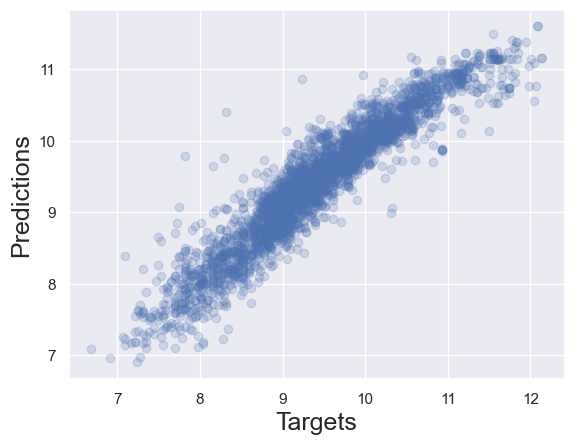

In [34]:
# Plot calculations in comparasion with targets
plt.scatter(targets_train, y_hat, alpha = 0.2)
plt.xlabel('Targets', size=18)
plt.ylabel('Predictions', size=18)
plt.show()

## Test model on test data

### Preprocessing of the test data

In [35]:
# Reset indexes
data_cleaned_test = test_data.reset_index(drop=True)

In [36]:
# Replace wrong EngineV data by median
data_cleaned_test.loc[data_cleaned_test['EngineV'] > 8, 'EngineV'] = data_cleaned_test['EngineV'].median()
data_cleaned_test.describe()

,Price,Mileage,EngineV,Year
count,805.000000,805.000000,805.000000,805.000000
mean,18297.659888,166.277019,2.452870,2006.344099
std,20081.200958,109.681726,0.937628,6.916316
min,1150.000000,0.000000,1.000000,1969.000000
25%,6999.000000,86.000000,1.900000,2003.000000
50%,11450.000000,163.000000,2.200000,2007.000000
75%,22500.000000,234.000000,3.000000,2012.000000
max,199999.000000,810.000000,6.300000,2016.000000


In [37]:
# Log transformation
log_price_test = np.log(data_cleaned_test['Price'])
data_cleaned_test['Log_Price'] = log_price_test
data_cleaned_test = data_cleaned_test.drop(['Price'], axis=1)


In [38]:
# Create dummies
data_with_dummies_test = pd.get_dummies(data_cleaned_test, drop_first=True)
data_with_dummies_test

,Mileage,EngineV,Year,Log_Price,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,97,3.5,2012,10.257659,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True
1,87,1.6,2008,9.093807,False,False,False,False,True,False,False,False,True,False,False,False,False,True,True
2,150,1.6,2001,8.787220,False,False,False,False,False,True,False,False,True,False,False,False,False,True,True
3,90,1.4,2003,8.985946,False,False,False,False,False,True,False,False,True,False,False,False,False,True,True
4,179,2.4,2006,9.323669,False,False,False,False,True,False,False,False,True,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,64,2.0,2015,10.968198,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True
801,100,3.0,2011,10.596610,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
802,60,1.6,2012,9.345745,False,False,True,False,False,False,False,False,True,False,False,True,False,False,True
803,250,1.9,1992,8.006368,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True


In [39]:
# Split to target and features
x_test = data_with_dummies_test.drop(['Log_Price'], axis=1)
y_test = data_with_dummies_test['Log_Price']
y_hat_test = reg.predict(x_test)

In [40]:
# Take exponential to get price predictions and targets
df_pf = pd.DataFrame(np.exp(y_hat_test), columns=['Prediction'])
df_pf['Target'] = np.exp(y_test)
df_pf

,Prediction,Target
0,33053.968332,28500.0
1,11520.997564,8900.0
2,5891.934799,6550.0
3,7158.800312,7990.0
4,10459.555872,11200.0
...,...,...
800,48065.216515,58000.0
801,39450.952450,39999.0
802,12712.230746,11450.0
803,2938.493716,3000.0


In [41]:
# Difference between targets and predictions
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']

In [42]:
df_pf.describe()

,Prediction,Target,Residual
count,805.000000,805.000000,805.000000
mean,16920.329830,18297.659888,1377.330058
std,14445.679106,20081.200958,9514.089653
min,801.112447,1150.000000,-28142.084316
25%,7134.181898,6999.000000,-1950.034188
50%,12631.057234,11450.000000,55.096753
75%,22178.263674,22500.000000,1820.841714
max,109130.227969,199999.000000,102239.925469


In [43]:
# Residual mean
df_pf['Residual'].mean()

1377.330058214061

In [44]:
# R2
r2= r2_score(df_pf['Target'], df_pf['Prediction'])
r2

0.7708214805020275

In [45]:
# MSE
mse = mean_squared_error(df_pf['Target'], df_pf['Prediction'])
mse



92302495.42164679

In [46]:
# MAE
mae = mean_absolute_error(df_pf['Target'], df_pf['Prediction'])
mae



4387.096817624854

In [47]:
# RMSE
rmse = mean_squared_error(df_pf['Target'], df_pf['Prediction'], squared=False)
rmse

9607.4187699739